In [1]:
# import pyforest
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix
import sys 
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
import scipy as sp
from sklearn.metrics import pairwise_distances

# ---------------------------------------------
def calc_AD_kmean_dist(train_dset, pred_dset, k, train_dset_pair_distance=None, dist_metric="euclidean"):
    """
    calculate the probability of the prediction dataset fall in the the domain of traning set. Use Euclidean distance of the K nearest neighbours.
    train_dset and pred_dset should be in 2D numpy array format where each row is a compound.
    """
    if train_dset_pair_distance is None:
        # calcualate the pairwise distance of training set
        train_dset_pair_distance = pairwise_distances(X=train_dset, metric=dist_metric)
    train_kmean_dis = []
    for i in range(len(train_dset_pair_distance)):
        kn_idx = np.argpartition(train_dset_pair_distance[i], k+1)
        dis = np.mean(train_dset_pair_distance[i][kn_idx[:k+1]])
        train_kmean_dis.append(dis)
    train_dset_distribution = sp.stats.norm.fit(train_kmean_dis)
    # pairwise distance between train and pred set
    pred_size = len(pred_dset)
    train_pred_dis = pairwise_distances(X=pred_dset, Y=train_dset, metric=dist_metric)
    pred_kmean_dis_score = np.zeros(pred_size)
    for i in range(pred_size):
        pred_km_dis = np.mean(np.sort(train_pred_dis[i])[:k])
        train_dset_std = train_dset_distribution[1] if train_dset_distribution[1] != 0 else 1e-6
        pred_kmean_dis_score[i] = max(1e-6, (pred_km_dis-train_dset_distribution[0]) / train_dset_std)
    return pred_kmean_dis_score

In [3]:
def prediction_type(y_true, y_pred): 
    if (y_true == 0 and y_pred == 0): 
        return 'TN'
    elif (y_true == 0 and y_pred == 1): 
        return 'FP'
    elif (y_true == 1 and y_pred ==0): 
        return 'FN'
    elif (y_true == 1 and y_pred ==1): 
        return 'TP'
    else: 
        return 'error'

In [61]:
results_path='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/GP_results/'
datapath='/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/datasets/80train_20test/featurized/'
neks = ['NEK2_binding','NEK2_inhibition','NEK3_binding','NEK5_binding','NEK9_binding','NEK9_inhibition']
samplings =['none_scaled','UNDER','SMOTE','ADASYN'] 
feats=['MOE','MFP'] 
kernel_types = ['matern', 'RBF']


In [63]:
pred_markers = {'TP': 'D','TN': 'o', 'FP': 'o', 'FN': 'o'}
pred_sizes = {'TP': 100, 'TN': 95, 'FP': 97, 'FN': 97}
pred_palette = {'TP':'black', 'TN':'#9792E3', 'FP':'#ED9B40', 'FN':'#DC493A'}
def GP_scatter_varpred_AD_sbuplots(df,ax, figure_path=None, filename=None):
    true_labels = df['y'] 

    tp_indices = np.where((df['prediction'] == 1) & (true_labels == 1))[0]
    tn_indices = np.where((df['prediction'] == 0) & (true_labels == 0))[0]
    fp_indices = np.where((df['prediction'] == 1) & (true_labels == 0))[0]
    fn_indices = np.where((df['prediction'] == 0) & (true_labels == 1))[0]
    
    df['prediction variance'] = np.nan
    df.loc[tp_indices, 'prediction variance'] = df.loc[tp_indices, 'var1']
    df.loc[fp_indices, 'prediction variance'] = df.loc[fp_indices, 'var1']
    df.loc[tn_indices, 'prediction variance'] = df.loc[tn_indices, 'var0']
    df.loc[fn_indices, 'prediction variance'] = df.loc[fn_indices, 'var0']
    
    feat=df['feat_type'].iloc[0]
    samp=df['strategy'].iloc[0]
    sizes = df['prediction_type'].map(pred_sizes)

    sns.scatterplot(data=df, x='ADdist', y='prediction variance', hue='prediction_type', palette=pred_palette,
           markers=pred_markers, style='prediction_type',ax=ax,s=120,alpha=0.75)
    samp_label=f'{df["feat_type"].iloc[0]} {df["strategy"].iloc[0]}'
    title = f'{samp_label}\n1-specificity: {df["1-specificity"].iloc[0]:.2f}, sensitivity: {df["recall"].iloc[0]:.2f}'
    ax.set_title(f'{title}',fontsize=16)
    ax.set_yticks(np.arange(0,9, step=1))
    ax.get_legend().remove()
    # ax.legend(bbox_to_anchor=(1.02, .99),fontsize=16)
    ax.set_xlabel('ADdist', fontsize=16)
    ax.set_ylabel('Prediction Variance', fontsize=16)
    ax.set_ylim(-0.1, 9)
    ax.set_xlim(-.30,12) 



In [64]:
def get_plotting_data_GP_UQ(results_df,data_df): 
    drop_cols=['NEK'	,'compound_id',	'base_rdkit_smiles',	'subset'	,'active']
    train_df=data_df[data_df['subset']=='train'].drop(columns=drop_cols) 
    test_df=data_df[data_df['subset']=='test'].drop(columns=drop_cols) 
    test_dist = calc_AD_kmean_dist(train_df, test_df, k=7)
    # train_dist = calc_AD_kmean_dist(train_df, train_df, k=7)
    results_df=results_df.rename(columns={'y_pred':'prediction', 'var_pred_class0': 'var0', 'var_pred_class1': 'var1'})
    results_df['prediction_type'] = results_df.apply(lambda x: prediction_type(x['y'], x['prediction']), axis=1)
    results_df['ADdist'] = test_dist
    results_df['1-specificity'] = 1-results_df['specificity'] 
    
    return test_dist, results_df
 

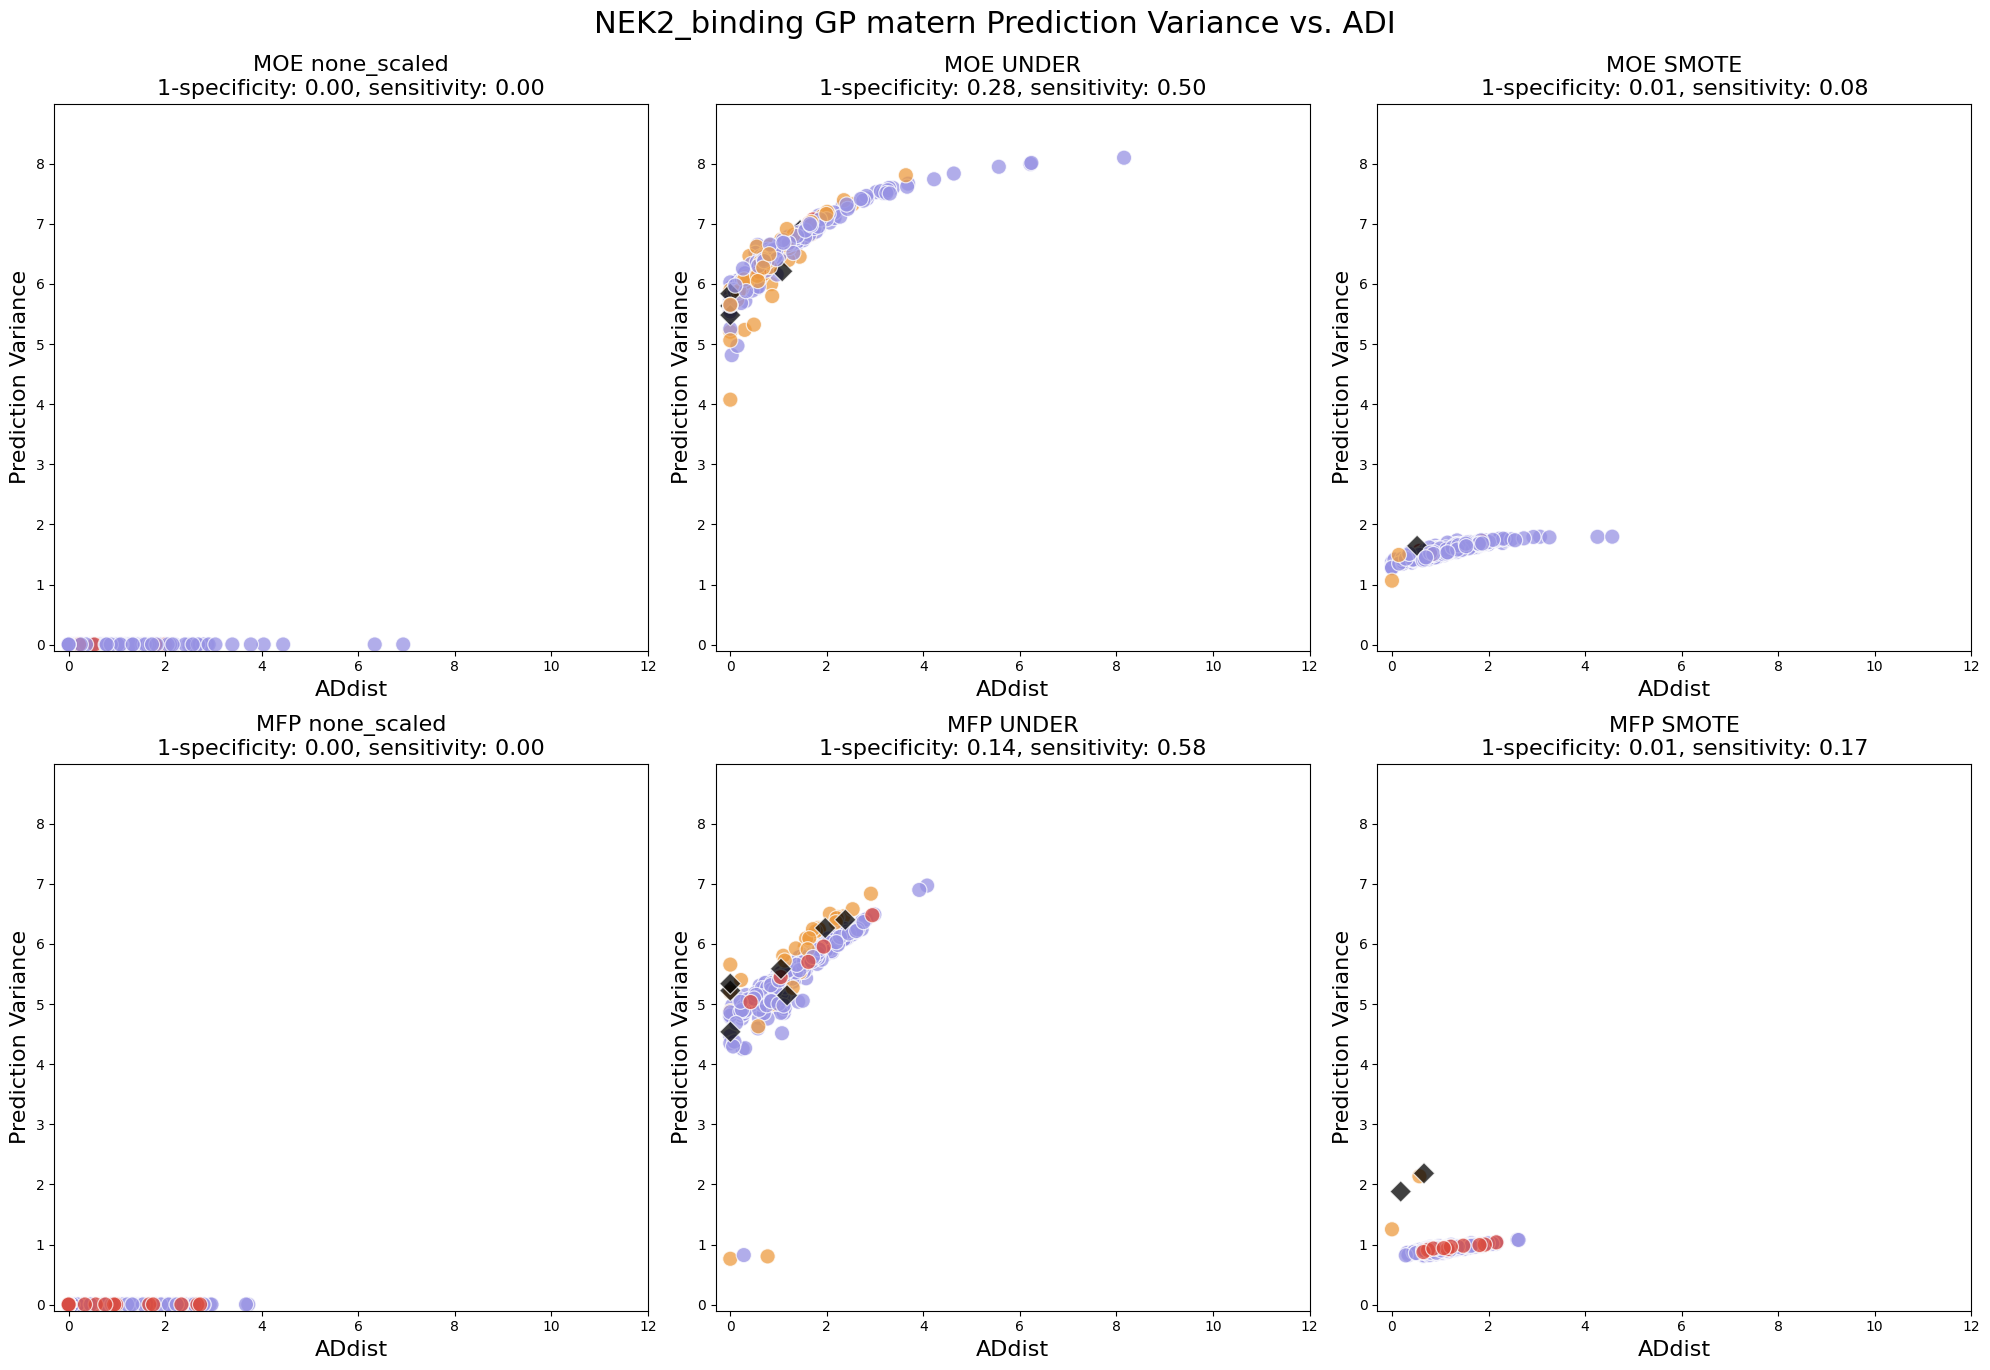

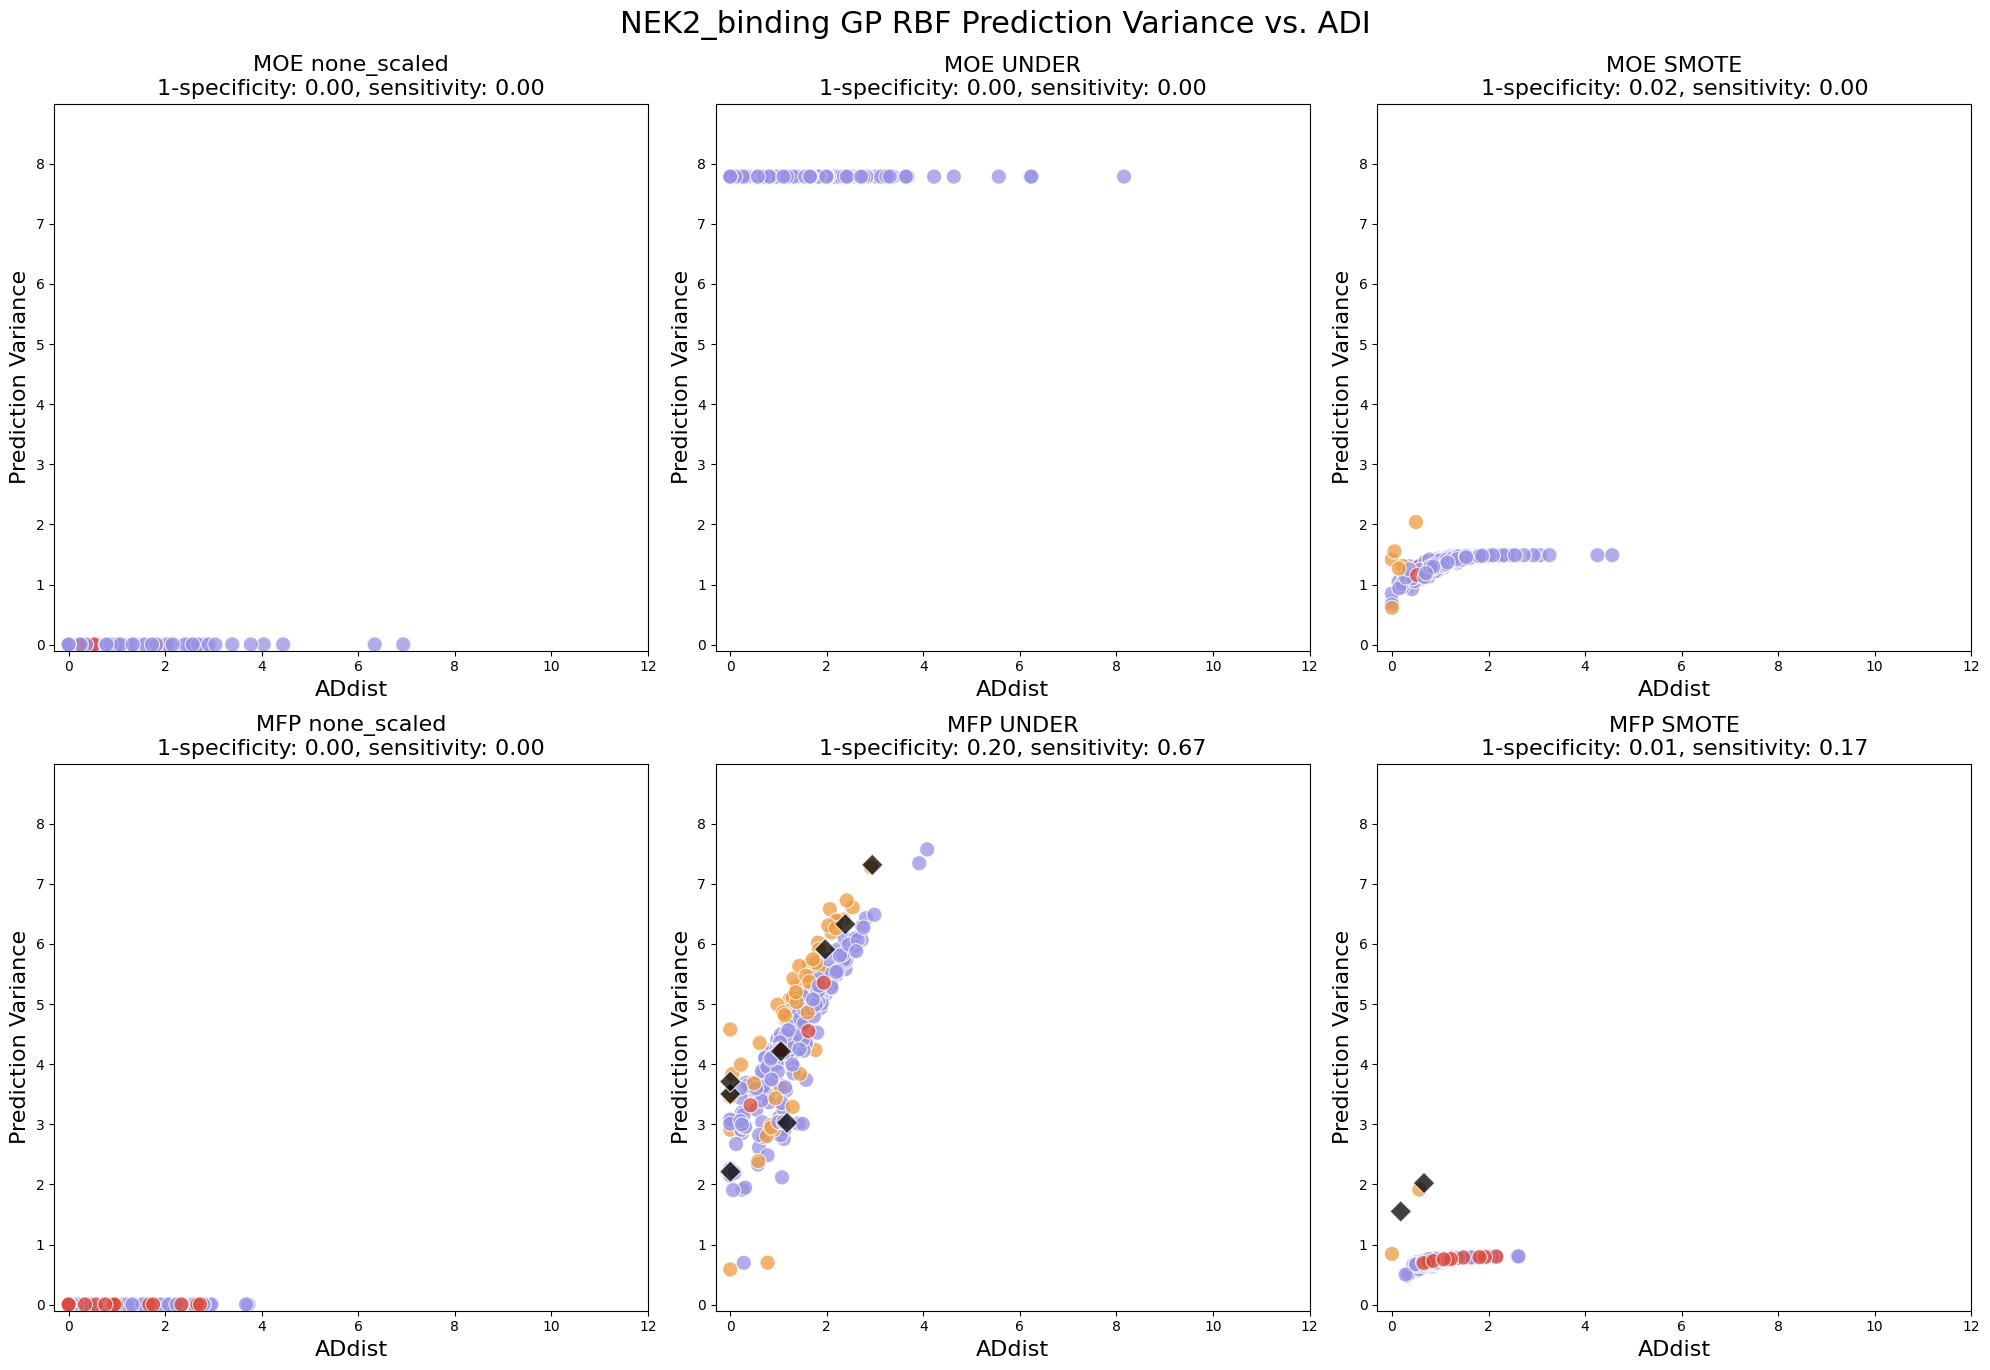

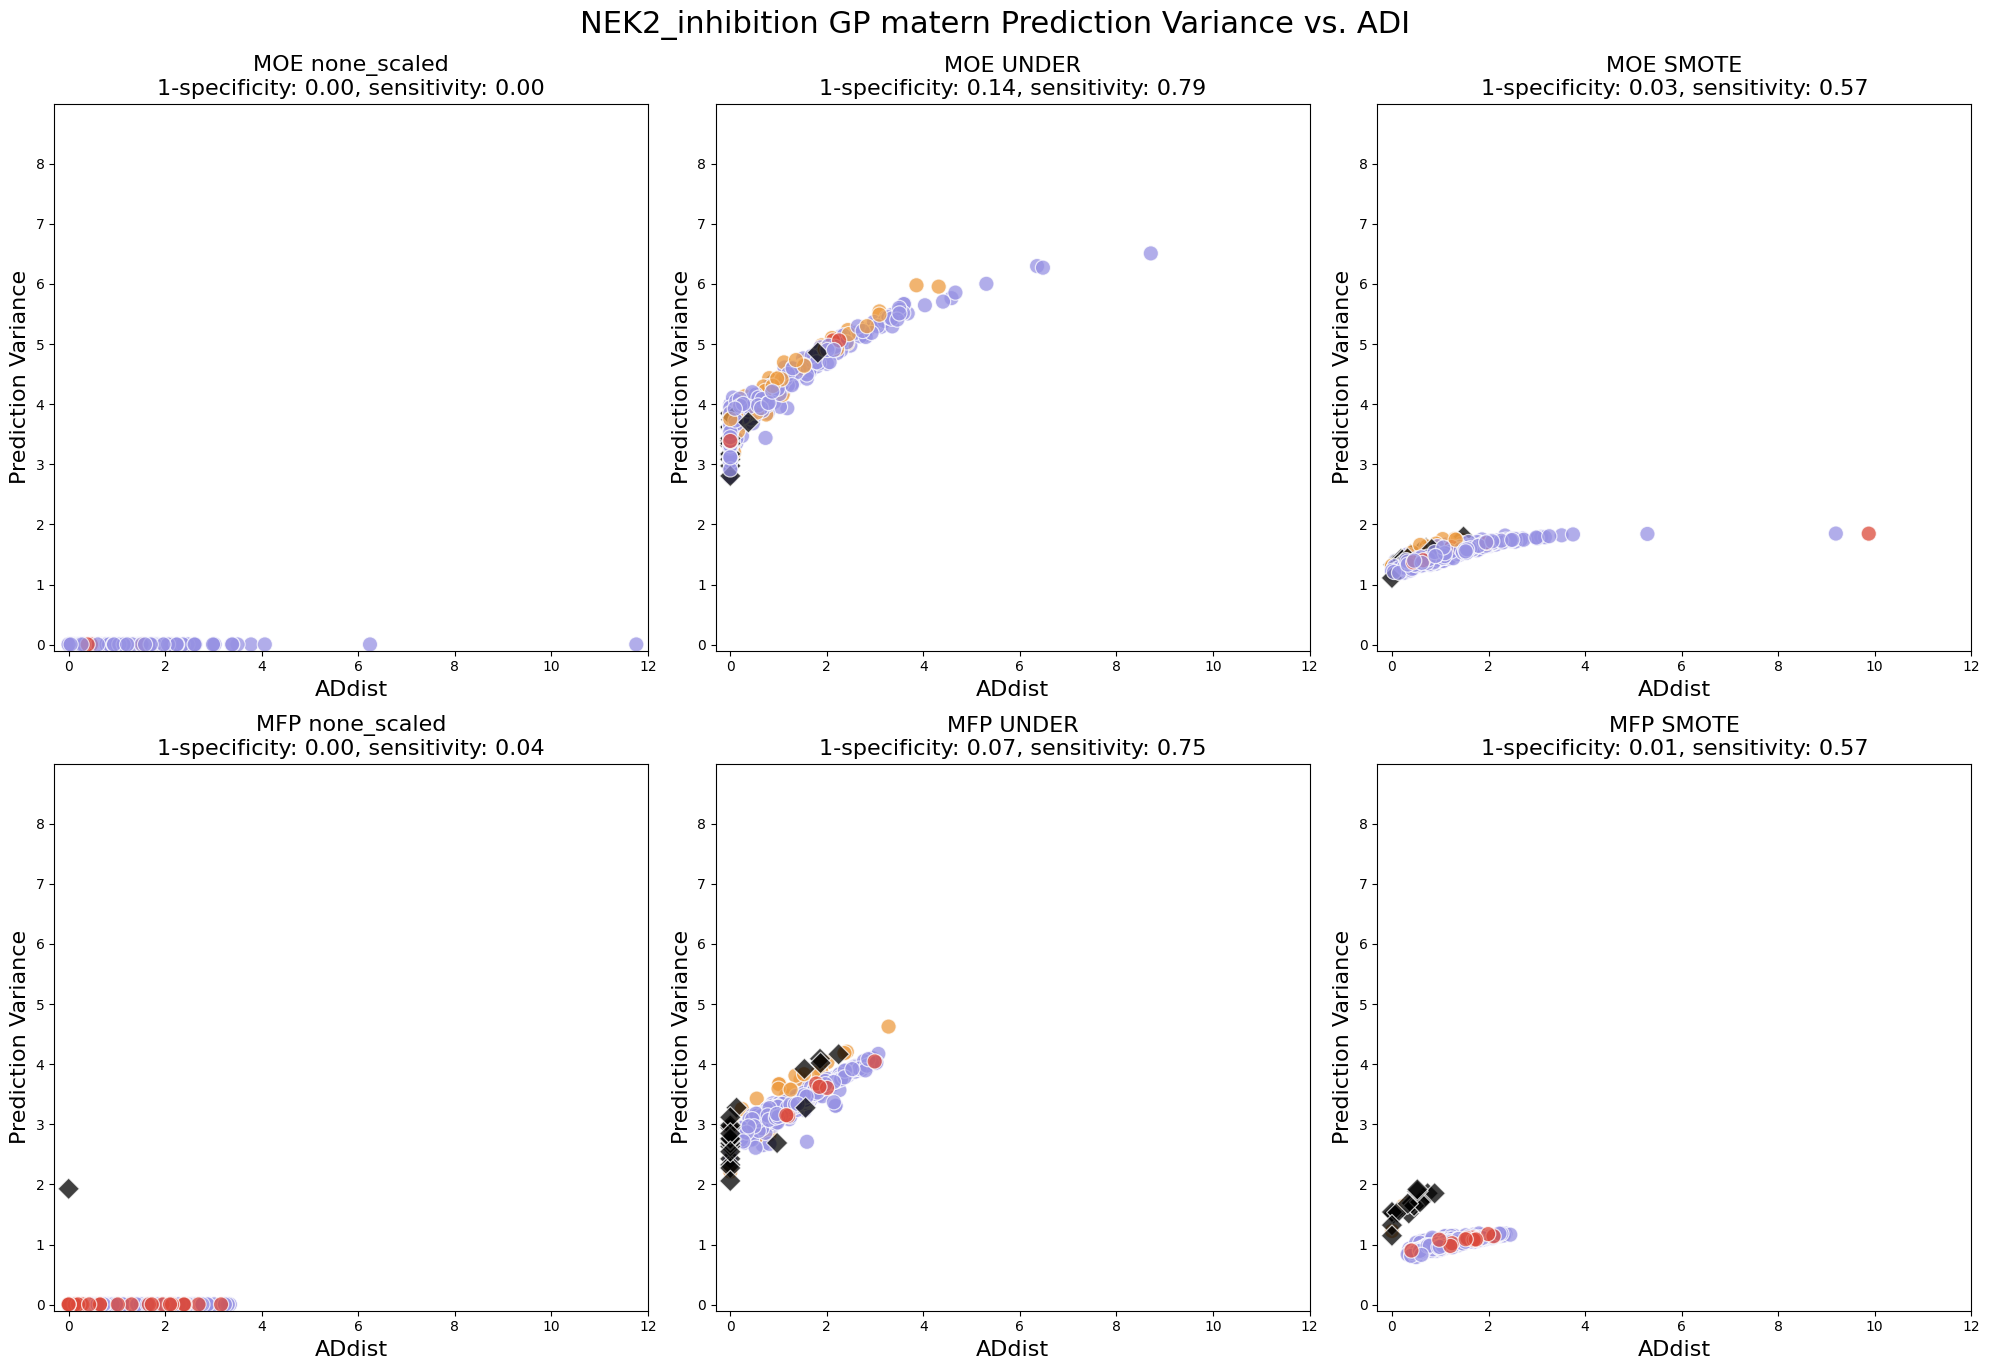

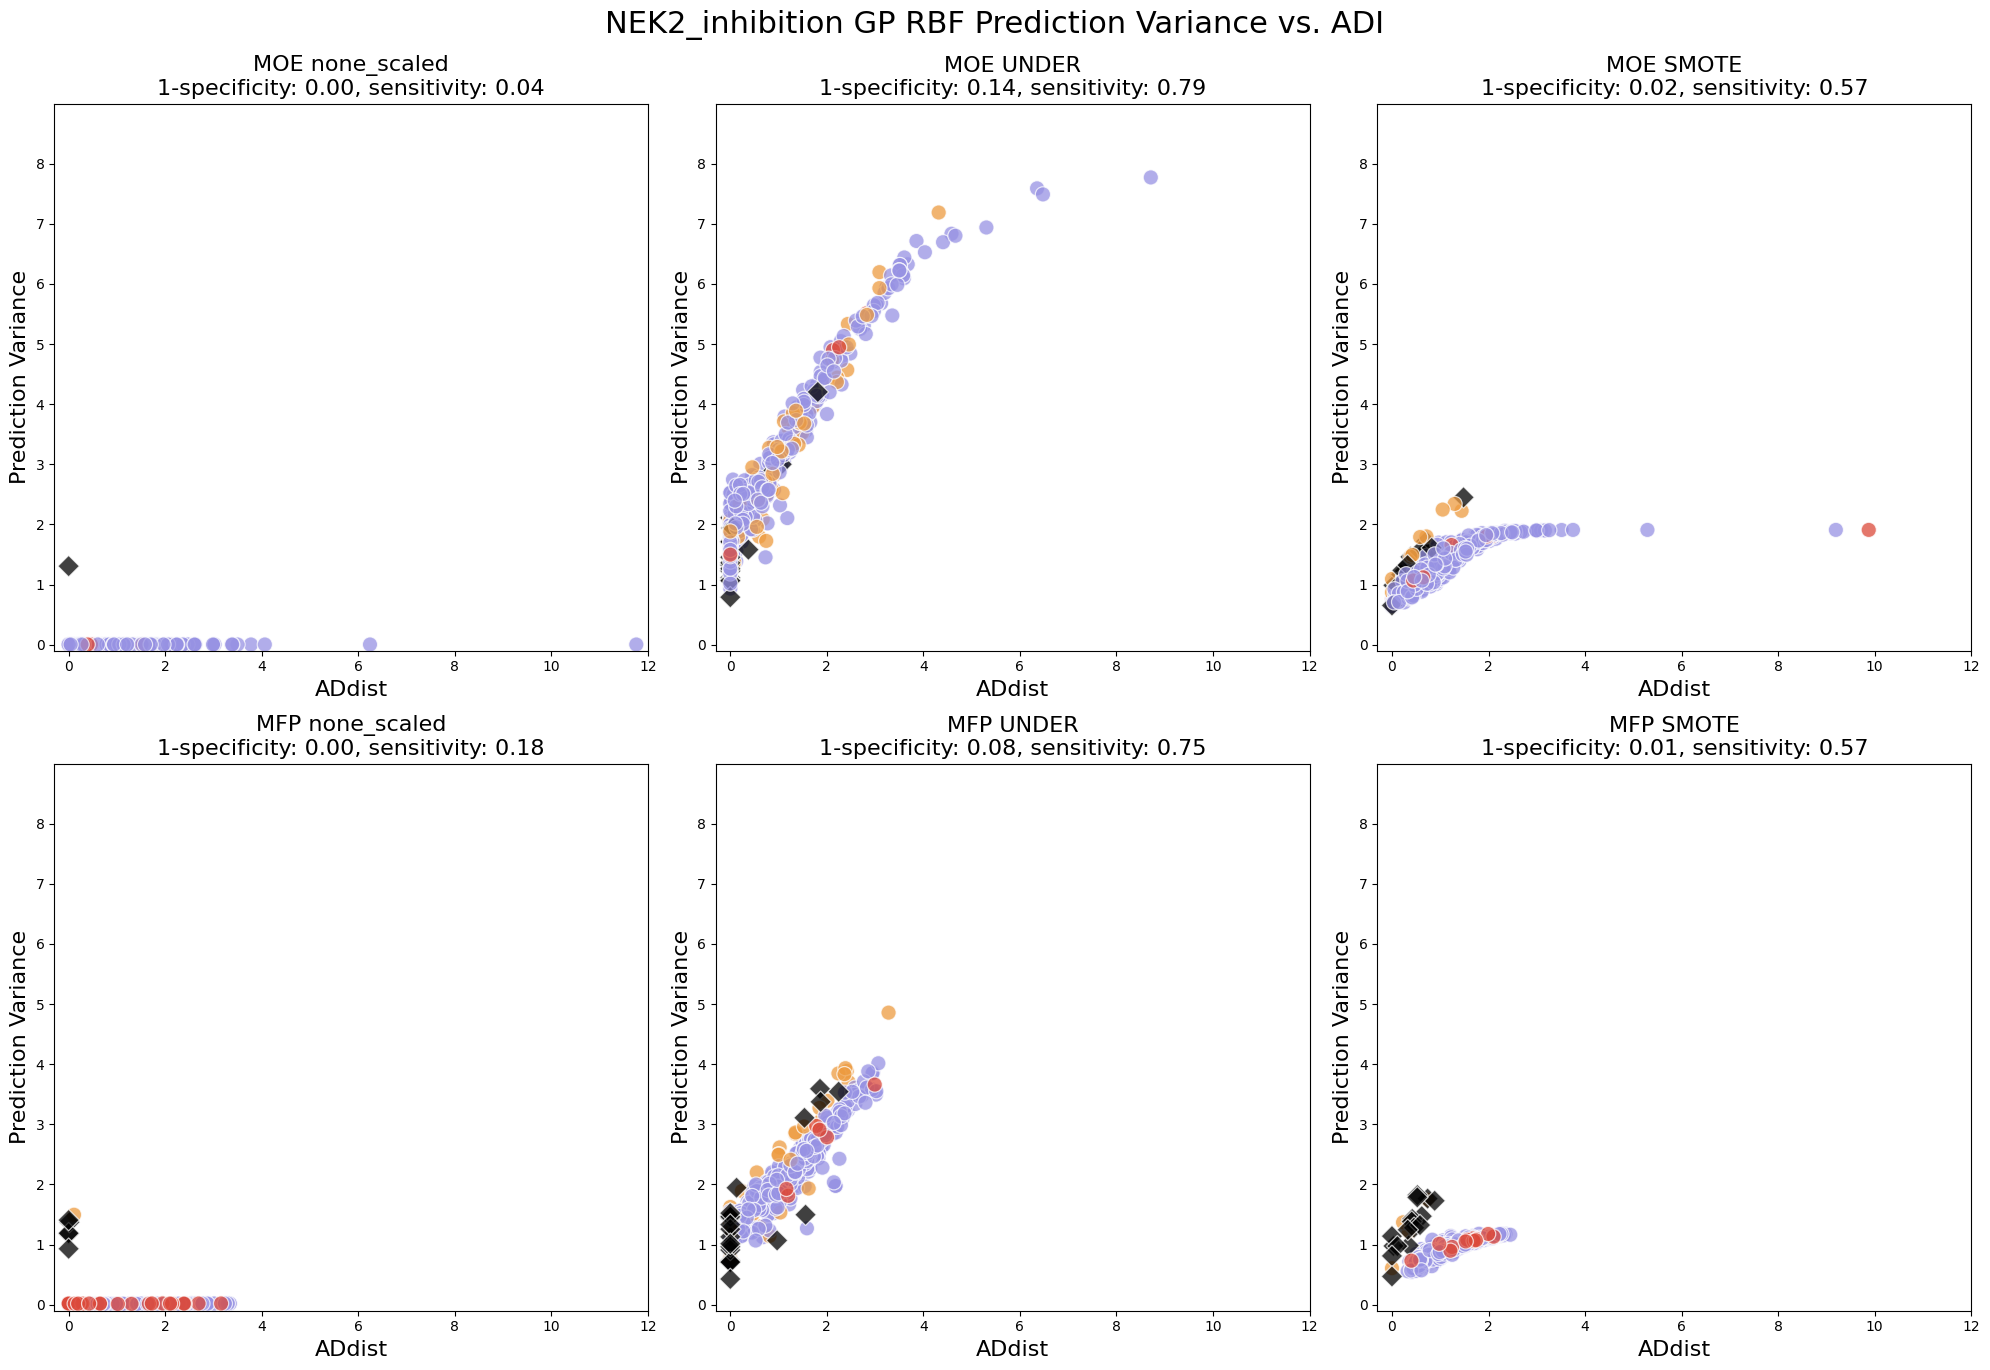

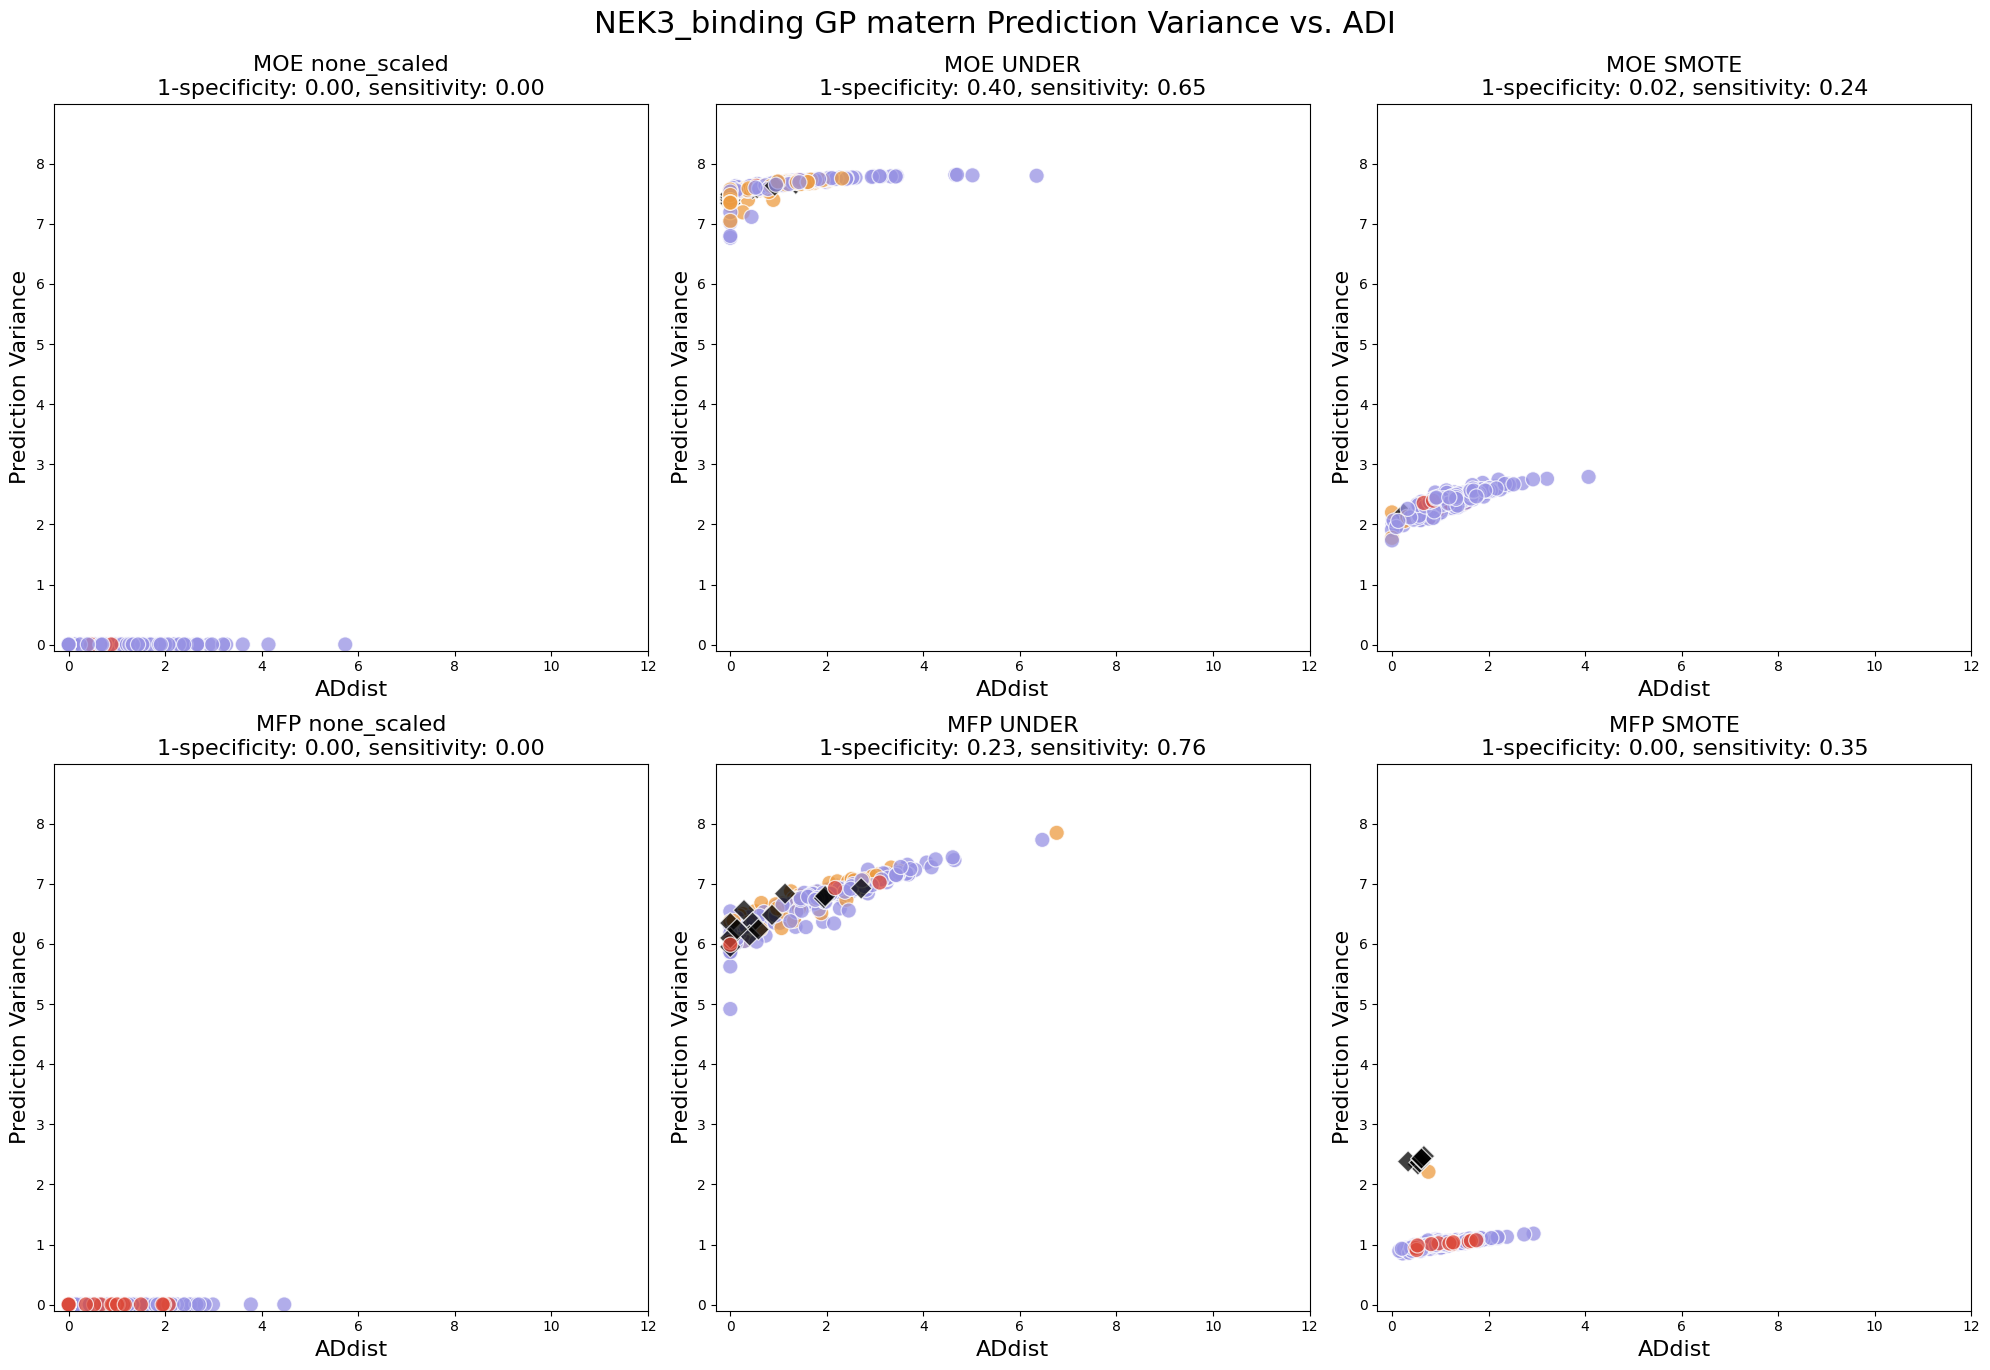

In [ ]:
figure_path5=f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/UQ/GP/'
def change_names(df): 
    df['strategy']=df['strategy'].replace('none_scaled', 'no_samp') 
    df['strategy']=df['strategy'].replace('BRFC', 'Bstrp Under') 
    df['strategy']=df['strategy'].replace('BRFC_BCW', 'Bstrp Under BalWeight') 
    df['strategy'] = df['strategy'].replace('RF_BCW','RF_BalWeight')
    return df
# 2 rows: row 1 is MOE, row 2 is MFP
# either 3 or 4 rows for sampling techniques 
samplings =['none_scaled','UNDER','SMOTE']  # removing ADASYN for now
for nek in neks:
    for kernel in kernel_types: 
        fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))
        fig.suptitle(f'{nek} GP {kernel} Prediction Variance vs. ADI', fontsize=22,y=0.94)
        count=0
        for i,feat in enumerate(feats): 
            for j,samp in enumerate(samplings): 
                ax =axes[i,j]
                count += 1
                # print(f'{i}, {j} {nek}_{feat}_{samp}_{kernel}')
                root_name = f'{nek}_{feat}_{samp}'
                results_df = pd.read_csv(f'{results_path}{nek}_{feat}_{samp}_{kernel}_prod_test.csv')
                data_df = pd.read_csv(f'{datapath}{root_name}.csv')
                test_dist, results_df=get_plotting_data_GP_UQ(results_df,data_df)
                
                GP_scatter_varpred_AD_sbuplots(results_df,ax)
                
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        fig.savefig(f'{figure_path5}{nek}_{kernel}_UQ_scatter.png', bbox_inches='tight')
        
       